<a href="https://colab.research.google.com/github/seel-channel/AMPD_Mask_RCNN/blob/master/Train_Mask_RCNN_(AMPD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Installation**

Load your dataset

In [ ]:
%tensorflow_version 1.x
!pip install --upgrade h5py==2.10.0
!git clone https://github.com/seel-channel/AMPD_Mask_RCNN
%matplotlib inline

In [2]:
import sys
sys.path.append("/content/AMPD_Mask_RCNN")
from train_mask_rcnn import *

VERS 0.2


Using TensorFlow backend.


... done downloading pretrained model!


In [ ]:
!nvidia-smi

rm: cannot remove 'Mask_RCNN/': Is a directory


## **2. Image Dataset**

Load your annotated dataset


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Extract Images
drive_folder = "/content/gdrive/MyDrive/ampd/"
cache_folder = "/content/dataset/"
test_folder = cache_folder + "test/"
train_folder = cache_folder + "train/"

images_folder = "images/"
generated_folder = "generated/"
annotations_filename = "coco_annotations.json"

train_annotations_path = train_folder + annotations_filename
test_annotations_path = test_folder + annotations_filename

print("Extracting: train")
extract_images(drive_folder + "dataset_train.zip", train_folder)
print("Extracting: test")
extract_images(drive_folder + "dataset_test.zip", test_folder)

Extracting: train
Extracted: 9998 images
Extracting: test
Extracted: 501 images


In [5]:
import json

def open_json(path: str):
    with open(path) as f:
        return json.loads(f.read())

def save_json(dict: dict, path: str):
    with open(path, 'w+') as f:
        json.dump(dict, f)

def remove_unused_images(annotations_path):
  coco_json = open_json(annotations_path)
  used_images = []
  images = []

  for annotation in coco_json['annotations']:
    image_id = annotation['image_id']
    if not image_id in used_images:
        used_images.append(image_id)
  
  for image in coco_json['images']:
    image_id = image['id']
    if image_id in used_images:
      images.append(image)

  coco_json['images'] = images
  save_json(coco_json, annotations_path)

# Ignore images without annotations
print("Removing train unused images...")
remove_unused_images(train_annotations_path)
print("Removing test unused images...")
remove_unused_images(test_annotations_path)

Removing train's useless images...
Removing test's useless images...


In [6]:
dataset_train = load_image_dataset(train_annotations_path, train_folder, "train")
dataset_val = load_image_dataset(test_annotations_path,  test_folder, "val")
class_number = dataset_train.count_classes()
print('Train: %d' % len(dataset_train.image_ids))
print('Validation: %d' % len(dataset_val.image_ids))
print("Classes: {}".format(class_number))

Annotation json path:  /content/dataset/train/coco_annotations.json
Annotation json path:  /content/dataset/test/coco_annotations.json
Train: 8829
Validation: 55
Classes: 2


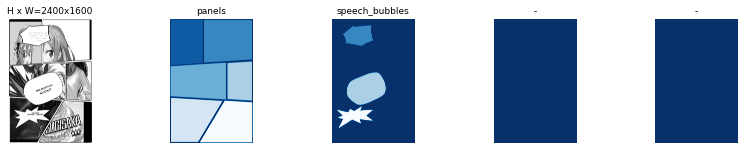

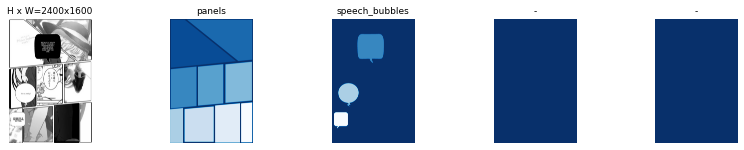

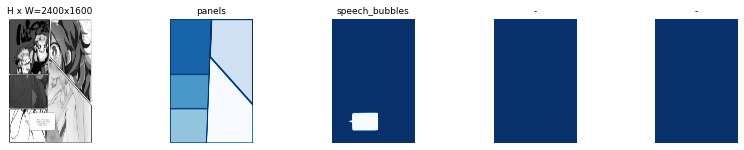

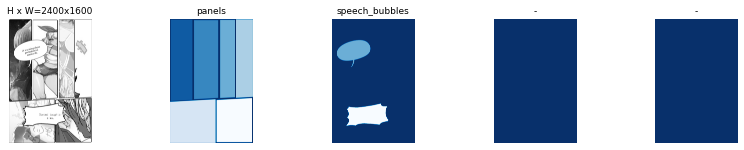

In [7]:
# Load image samples
display_image_samples(dataset_train)

##**3. Training**

Train Mask RCNN on your custom Dataset.

In [9]:
# Load Configuration
import os

def make_folders(folders: list, remove=False):
    for path in folders:
        if not os.path.exists(path):
            os.makedirs(path)
        elif(remove):
            os.remove(path)

model_dir = drive_folder + "pretrained/"
make_folders([model_dir])

config = CustomConfig(class_number)
model = load_training_model(config, model_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
/content/Mask_RCNN/mask_rcnn_coco.h5


In [11]:
# Start Training. This operation might take a long time.
train_head(model, dataset_train, dataset_train, config, epochs=10)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/MyDrive/ampd/model/object20211122T0339/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

## **4. Detection (test your model on a random image)**

In [12]:
# Load the latest trained model will be loaded
test_model, inference_config = load_test_model(class_number, model_dir)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/gdrive/MyDrive/ampd/model/object20211122T0339/mask_rcnn_object_0010.h5
Re-starting from epoch 10


original_image           shape: (832, 832, 3)         min:    0.00000  max:  255.00000  uint8
Trained model result
Processing 1 images
image                    shape: (832, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.43567  max:    1.35865  float32
Annotation


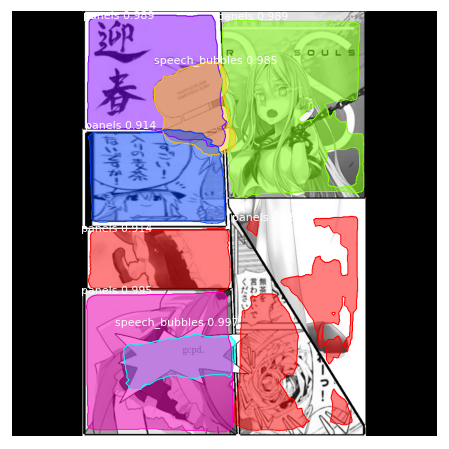

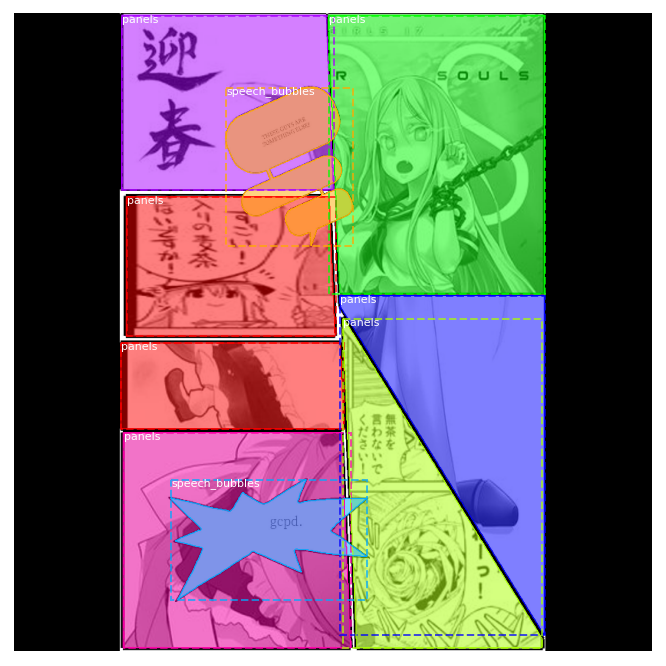

In [23]:
# Test on a random image
test_random_image(test_model, dataset_val, inference_config)